<a href="https://colab.research.google.com/github/Anyaoma/My-projects/blob/main/Interest_rate_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### The main goal of this analysis is to predict future interest rate direction. the sub goals include:

1. Interpolate the Euribor term structure using cubic spline interpolation method.
2. Obtain the forwards rate implied from the euribor term structure.
3. Perform calibration in order to derive the CIR model parameters  ($\kappa_r$, $\theta_r$, $\sigma_r$, $r_0$) so to minimize the differences between the rates produced by the model, and the rates observed in practice.
4. Step 3 will be carried out using the CIR forward rate model and forward rate derived from interpolated Euribor term structure.


Since we do not typically get quotes for the forwards rate in the market, which is what we need for calibrating our model, and we have just the Euribor rates or yields for different maturities, there is a very simple way of going from bond yields to forward rates and vice versa. Suppose $Y(0, T)$ is the current bond yield (short rate) of a ZCB that pays 1 unit at maturity $T$:
$$
\
\begin{equation*}
    f(0, T) = Y(0, T) + \frac{\partial Y(0, T)}{\partial T}T
\end{equation*}
$$
\
Simultaneously, we know that the price of that bond today, given yield $Y(0, T)$ should solve the following equation:
$$
\
\begin{equation*}
    B_T(T) = B_0(T) e^{Y(0,T) T} \Leftrightarrow Y(0,T) = \frac{log B_T(T) - log B_0(T)}{T}
\end{equation*}
$$
\
and since we have normalized the face value of the bond at maturity to 1:
$$
\
\begin{equation*}
    Y(0,T) = -\frac{log B_0(T)}{T}
\end{equation*}
$$
\

The Cox-Ingersol-Ross model has the following general SDE:
$$
\
\begin{equation*}
  dr_t = k_r(\theta_r-r_t)dt + \sigma_r \sqrt{r_t} dz_t
\end{equation*}
$$

where:

r_t : The instantaneous interest rate at time t

k_r : speed of mean reversion. This is the rate at which r_t reverts back to the long term mean level θ.

θ_r : (long-term mean level): The long-term mean level of the interest rate. The model assumes that over time, r_t will revert back to its mean level.

σ_r : (volatility): The volatility coefficient of the interest rate process. It determines the intensity of the randomness in r_t
and scales with √r_t meaning that volatility decreases as r_t approaches zero.

z_t : A standard Wiener process (Brownian motion), representing the source of randomness in the model.

The CIR SDE models interest rate as a mean reverting random process, whose volatility increases with higher values of iterest rate and reduces as interest rate approaches zero.

In [ ]:
mat_list = np.array((1, 30, 90, 180, 360)) / 360
euribor = np.array((3.3375, 3.2055, 3.0016, 2.6913, 3.1666))/100

In [ ]:
r0 = euribor[0]
factors = 1 + mat_list * euribor
zero_rates = 1 / mat_list * np.log(factors)
zero_rates #annualised rates

array([0.03337345, 0.03201226, 0.02990394, 0.02673353, 0.03117497])

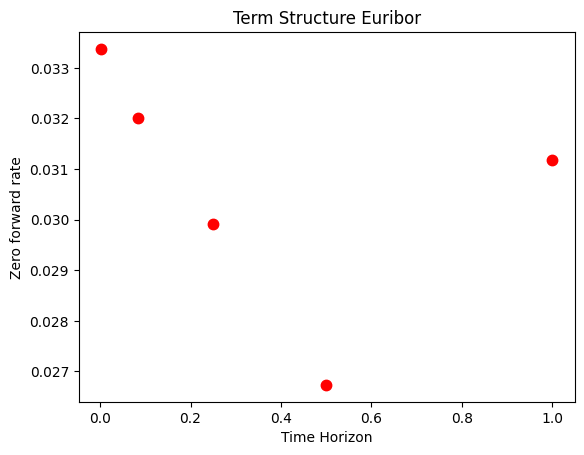

In [ ]:
plt.plot(mat_list, zero_rates, "r.", markersize="15")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.show()

In [ ]:
data = pd.read_csv('data.csv')
data.head()

,Maturity,07-Nov-24
0,0.25,2.842155
1,0.50,2.653649
2,0.75,2.506712
3,1.00,2.393088
4,2.00,2.158028


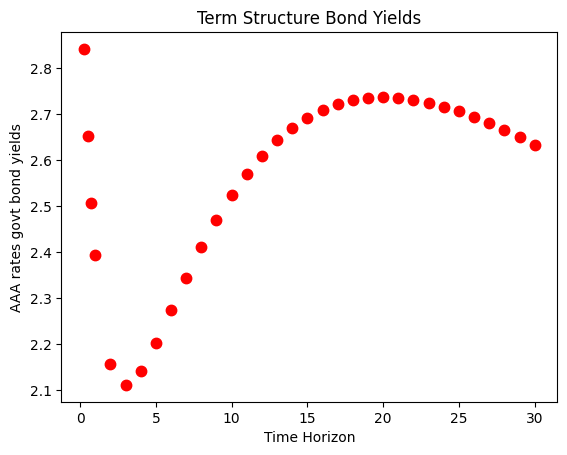

In [ ]:
plt.plot(data['Maturity'], data['07-Nov-24'], "r.", markersize="15")
plt.xlabel("Time Horizon")
plt.ylabel("AAA rates govt bond yields")
plt.title("Term Structure Bond Yields")
plt.show()

##Interpolation ofeuribor rates

In [ ]:
from scipy.interpolate import splev, splrep

In [ ]:
cubic_spline = splrep(mat_list, zero_rates, k=3)  # Cubic spline object
maturity_li = np.linspace(0.0, 1.0, 52)  # Create 52 equally spaced maturities between 0 and 1
inter_rates = splev(maturity_li, cubic_spline, der=0)  # Interpolated rates

first_der = splev(maturity_li, cubic_spline, der=1)  # First derivative of spline
f = (inter_rates + first_der * maturity_li)  # Forward rate given interpolated ones and first derivative

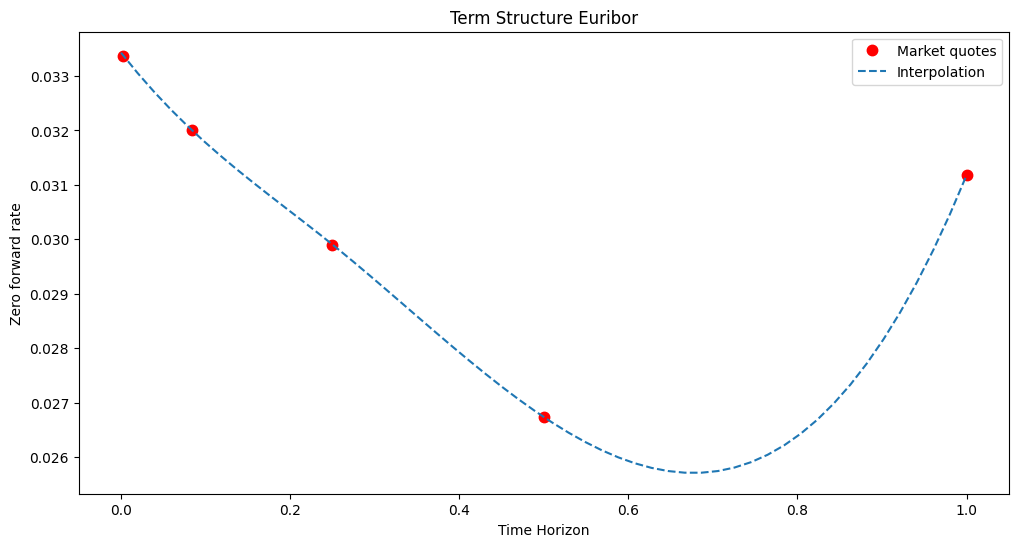

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(mat_list, zero_rates, "r.", markersize="15", label="Market quotes")
plt.plot(maturity_li, inter_rates, "--", markersize="10", label="Interpolation")
#plt.plot(maturity_li, first_der, "g--", markersize="10", label="1st derivative")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Euribor")
plt.legend()
plt.show()

I will calibrate forward rates of the CIR (1985) model:


$$
\
\begin{equation*}
   f^{CIR}(t,T; \alpha) = \frac{\kappa_r \theta_r (e^{\gamma t}-1)}{2\gamma + (\kappa_r + \gamma)(e^{\gamma t}-1)} + r_0 \frac{4\gamma^2 e^{\gamma t}}{(2\gamma + (\kappa_r + \gamma)(e^{\gamma t}-1))^2}
\end{equation*}
$$



## Define the CIR forward rate function.

In [ ]:
def CIR_forward_rate(params):

    kappa_r, theta_r, sigma_r, = params

    t = maturity_li
    gamma = np.sqrt(kappa_r**2 + 2 * sigma_r**2)

    a1 = (kappa_r * theta_r * (np.exp(gamma * t) - 1)) / (2 * gamma + (kappa_r + gamma) * (np.exp(gamma * t) - 1))
    a2 = r0 * ((4 * gamma**2 * np.exp(gamma * t)) / (2 * gamma + (kappa_r + gamma) * (np.exp(gamma * t)) ** 2))

    return a1 + a2

## Define the error function

Using the mean squared error as the error function, the objective function i want to minimise is the:

$$
\
\begin{equation*}
  min \frac{1}{M} \sum_{m=0}^{M} \left( f(0,m\Delta t) - f^{CIR}(0,m\Delta t; \alpha) \right)^2
\end{equation*}
$$
\
with $M = T / \Delta t$, that is, the number of market data points between $0$ and $T$.

In [ ]:
def CIR_error_function(params):
    """
    Error function to calibrate CIR (1985) model
    """

    kappa_r, theta_r, sigma_r = params

    # Few remarks to avoid problems for certain values of parameters:
    if 2 * kappa_r * theta_r < sigma_r**2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100

    forward_rates = CIR_forward_rate(params)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)

    return MSE

## Define Optimization function

In [ ]:
from scipy.optimize import fmin

In [ ]:
def CIR_calibration(): #Using the gradient descent method, the fmin method finds the parameters that minimises the error function
    opt = fmin(
        CIR_error_function,
        [1.0, 0.02, 0.1],
        xtol=0.00001,
        ftol=0.00001,
        maxiter=300,
        maxfun=500,
    )

    return opt

## Results

In [ ]:
params = CIR_calibration()
params

<ipython-input-34-079d41514af3>:2: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  opt = fmin(


array([0.06741101, 0.72668242, 0.31300566])

In [ ]:
#Test of fit of the model
forward_rates = CIR_forward_rate(params)

In [ ]:
forward_rates

array([0.01897319, 0.01949741, 0.02001972, 0.02054007, 0.02105845,
       0.02157481, 0.02208913, 0.02260137, 0.02311151, 0.02361951,
       0.02412536, 0.02462901, 0.02513044, 0.02562963, 0.02612655,
       0.02662117, 0.02711347, 0.02760342, 0.028091  , 0.02857618,
       0.02905895, 0.02953928, 0.03001716, 0.03049255, 0.03096544,
       0.03143581, 0.03190365, 0.03236893, 0.03283164, 0.03329176,
       0.03374928, 0.03420417, 0.03465644, 0.03510606, 0.03555303,
       0.03599732, 0.03643893, 0.03687785, 0.03731408, 0.03774759,
       0.03817838, 0.03860645, 0.03903179, 0.03945439, 0.03987424,
       0.04029135, 0.04070571, 0.04111731, 0.04152616, 0.04193225,
       0.04233558, 0.04273615])

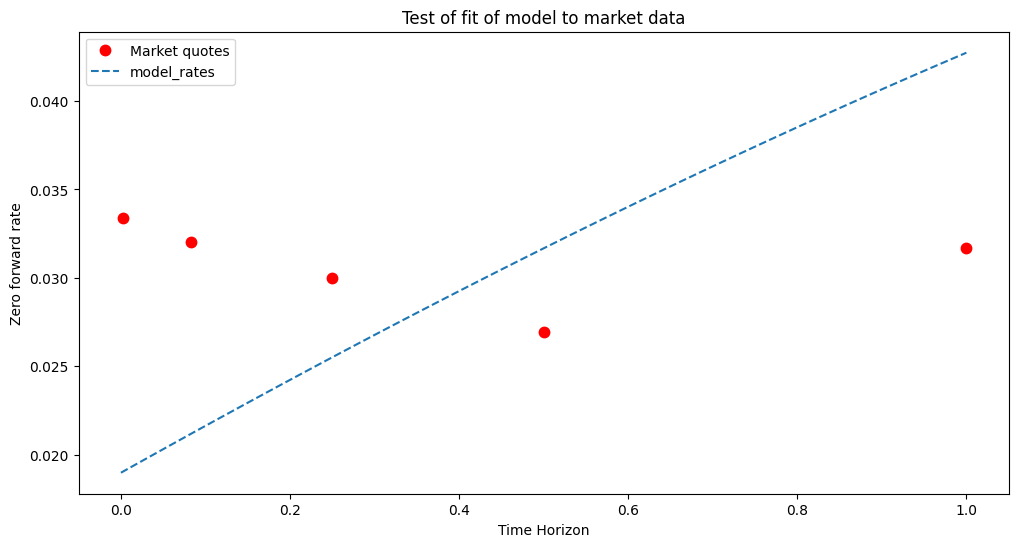

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(mat_list, euribor, "r.", markersize="15", label="Market quotes")
plt.plot( maturity_li, forward_rates, "--", markersize="10", label="model_rates")
plt.xlabel("Time Horizon")
plt.ylabel("Zero forward rate")
plt.title("Test of fit of model to market data")
plt.legend()
plt.show()

In [ ]:
𝜅_𝑟=0.607

𝜃_𝑟=0.105

𝜎_𝑟=0.001

## Monte-carlo simulation of daily annualized 12 month Eribor rate over the period of one year

In [ ]:

# CIR model parameters
k_r = 0.1      # Mean reversion speed
theta_r = 0.02 # Long-term mean level
sigma_r = 0.02 # Volatility
initial_rate = 0.02 # Starting rate (e.g., 2%)

# Simulation parameters
num_days = 252   # 1 year of trading days
num_simulations = 100000
dt = 1 / 252     # Time step (daily)

# Initialize rate paths
rates = np.zeros((num_days, num_simulations))
rates[0, :] = initial_rate

# Monte Carlo Simulation using the CIR model
for t in range(1, num_days):
    z = np.random.normal(0, 1, num_simulations)  # Random component
    drift = k_r * (theta_r - rates[t-1, :]) * dt
    diffusion = sigma_r * np.sqrt(rates[t-1, :]) * np.sqrt(dt) * z
    rates[t, :] = rates[t-1, :] + drift + diffusion
    # Ensuring no negative rates
    rates[t, :] = np.maximum(rates[t, :], 0)

# Plotting a few paths for visualization
plt.figure(figsize=(10, 6))
for i in range(10):  # Plot 10 sample paths
    plt.plot(rates[:, i], lw=0.5)
plt.title("Sample Euribor 12-Month Rate Paths")
plt.xlabel("Days")
plt.ylabel("Interest Rate")
plt.show()

# Optional: Statistical summary
mean_rate = np.mean(rates, axis=1)
plt.plot(mean_rate, label="Average Path", color="black", linewidth=2)
plt.title("Average Euribor 12-Month Rate Path")
plt.xlabel("Days")
plt.ylabel("Interest Rate")
plt.legend()
plt.show()
